In [1]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# New imported libraries

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
DATA_DIR = "20_newsgroups"

## Functions from lab

In [3]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [4]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [5]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [6]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [7]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [8]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)

            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [9]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9167797699835702
Test accuracy: 0.686


### Q1 (a)

The feature set is the binary term of whether the word is in the top 1000 words or not. The amount of data, 70% of data is used as training data and the rest is made of testing data split randomly.The hyperparameter used for the logistic regression model is C=1.0 which is the inverse of regularization strength. Other hyperparameters are set to default.

### Q1 (b)

Modify the following function:

In [10]:
def binary_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Import the stopwords from nltk
    stopset = set(stopwords.words('english'))
    
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Before selecting most common numWords,remove the stopwords
    for word in list(news_cnt):
        if word in stopset:
            del news_cnt[word]
    
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    # Use a new tokenizer which seperates the word, lower case all the words,
    # split the intra words, remove the stop words and perform stemming.
    
    tokenizer = RegexpTokenizer(r'\w+')
    
    
    df_rows = []
    
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    improved_X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    improved_y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    
    X = improved_X
    y = improved_y
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [11]:
# get the baseline data
X, y = binary_improved_data(all_files)

# Write your code here:
# You need to split the data and train a logistic regression classifier.
# Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.914136724051718
Test accuracy: 0.704


After removing stop words, the accuracy of training data has increased from 91.2% to 91.4% and the testing accuracy increased from 69.7% to 70.4%

### Q1 (d)

Modify the partial code below

In [12]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    for i in range(0,num_tests):
        random_number = random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_number)

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        train_results.append(train_accuracy)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        test_results.append(test_accuracy)
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [13]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9127580541467246
Train confidence interval over 10 random splits: [0.9112542631073766, 0.9142618451860727]
Test mean accuracy over 10 random splits: 0.7054833333333332
Test confidence interval over 10 random splits: [0.7026266289762721, 0.7083400376903943]


The mean and 95% CI tells us that the single iteration of random split is not sufficient enough to check the accuracy, since the testing accuracy mean is most likely lower than the single iteration accuracy. Yes, they are more informative since we are training on different data sets every time.

### Q1 (f)

Modify the partial code below

In [14]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # Write your code here
    for i in range(0,num_tests):
        random_number = random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_number)

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # create a confusion matrix for one of the model 
        cm = confusion_matrix(y_test, y_test_predict)
        cm_list.append(cm)
    
    
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = pd.Panel(cm_list).sum(axis=0)
    
    # validate return type
    assert isinstance(combined_cm, pd.DataFrame), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


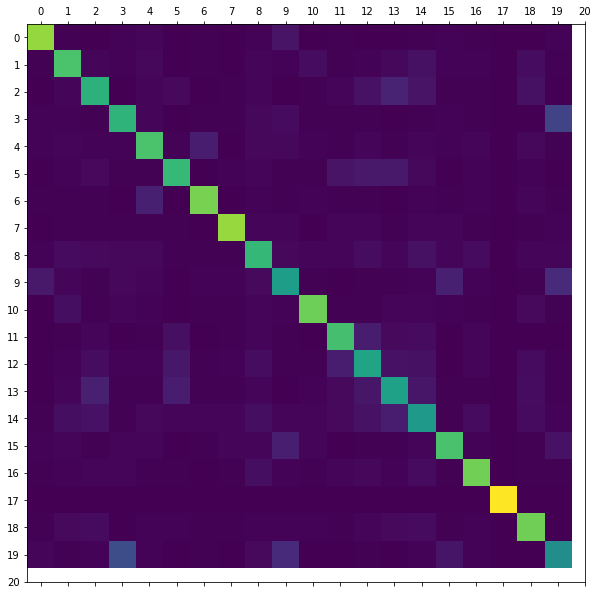

In [15]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

From the confusion matrix, we find that topic atheism and soc.religion.christian are easy to confuse. This makes sense since they both are topics about gods and religions. 

## Q2

### Q2 (a)

Modify the partial code below

In [16]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        # ......
        

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)

        # calculate train and test accuracy
        subset_train_accuracy = accuracy_score(y_train, y_train_predict)
        subset_test_accuracy = accuracy_score(y_test, y_test_predict)
        
        train_accuracy = subset_train_accuracy
        test_accuracy = subset_test_accuracy
        
        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

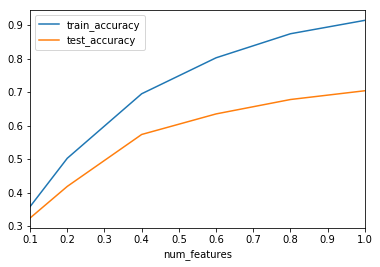

In [17]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

As more features are used, the train and test accuracy increases, however, the rate of increase in accuracy is slowing down. 

## Q3

### Q3 (a)

Modify the partial code below

In [18]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
        # ......
        
        # train a logistic regression classifier
        clf = LogisticRegression(C=param).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

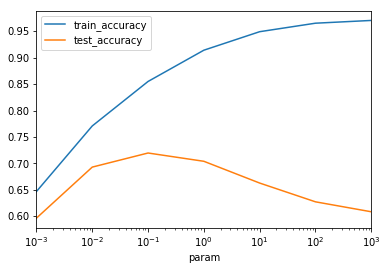

In [19]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

As more parameters are used, train accuracy increases. However, the testing accuracy decreases after parameter 0.1.

## Q4

### Q4 (a)

Modify the partial code below

In [20]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    
    # Import the stopwords from nltk
    stopset = set(stopwords.words('english'))
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    
    # Before selecting most common numWords,remove the stopwords
    for word in list(news_cnt):
        if word in stopset:
            del news_cnt[word]
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]

    
    # Create a binary encoding of dataset based on the selected features (X).
    
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    
    
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)

            df_rows.append([file_words.count(word) if word in file_words else 0 for word in word_list])      
                       
            
    improved_X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    improved_y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    
    X = improved_X
    y = improved_y
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [21]:
X_tf, y_tf = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.8924637474105293
Train confidence interval over 10 random splits: [0.8885971599818349, 0.8963303348392236]
Test mean accuracy over 10 random splits: 0.6943333333333335
Test confidence interval over 10 random splits: [0.6902602093910283, 0.6984064572756387]


The binary accuracy is higher than the term frequency since more irrelevant words are weighted higher in term frequency.

## Q5

### Q5 (a)

Modify the partial code below

In [22]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    
    for i in range(0,num_tests):
        random_number = random.randint(1,1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_number)

        # train a naive bayes regression classifier
        mnb = MultinomialNB()
        mnb_classifier = mnb.fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = mnb_classifier.predict(X_train)
        y_test_predict = mnb_classifier.predict(X_test)
        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        train_results.append(train_accuracy)
        test_accuracy = accuracy_score(y_test, y_test_predict)
        test_results.append(test_accuracy)
    
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [23]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.7431387956282591
Train confidence interval over 10 random splits: [0.740645050488334, 0.7456325407681843]
Test mean accuracy over 10 random splits: 0.6833333333333333
Test confidence interval over 10 random splits: [0.6769564987492076, 0.6897101679174591]


The accuracy for training and testing are both low comparted to before. This is due to the fact that naive bayes assumes independecy between all features, however, in our case, some document words are highly dependent with one another, resulting the low accuracy.

## Q6

In [24]:
def is_graduate_student():
    # ** Graduate students: change the return value to True **
    return True

### Q6 (a)

Modify the partial code below

In [25]:
def binary_med_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Import the stopwords from nltk
    stopset = set(stopwords.words('english'))

    # Before selecting most common numWords,remove the stopwords
    for word in list(news_cnt):
        if word in stopset:
            del news_cnt[word]
            
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]

    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)

            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    list_of_topic_name = [get_topic_name(file_path) for file_path in all_files]
    y = []
    for i in list_of_topic_name:
        if i == 'sci.med':
            y.append(1)
        else:
            y.append(0)
    
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [26]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9845560397171228
Train confidence interval over 10 random splits: [0.9840158862871436, 0.985096193147102]
Test mean accuracy over 10 random splits: 0.9680833333333332
Test confidence interval over 10 random splits: [0.9673266672381321, 0.9688399994285343]


The average and 95% CI shows that the binary med data is much higher than the multiclass logistic regression. 